In [2]:
# from google.colab import files
# files.upload()  # upload kaggle.json here


In [3]:
# Setup kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Install kaggle API client
!pip install -q kaggle


In [5]:
# Download competition data

!kaggle competitions download -c avito-demand-prediction -f train.csv
!kaggle competitions download -c avito-demand-prediction -f test.csv
!kaggle competitions download -c avito-demand-prediction -f sample_submission.csv


 81% 258M/318M [00:00<00:00, 1.35GB/s]
100% 318M/318M [00:00<00:00, 1.34GB/s]
  0% 0.00/111M [00:00<?, ?B/s]
100% 111M/111M [00:00<00:00, 1.35GB/s]
  0% 0.00/3.95M [00:00<?, ?B/s]
100% 3.95M/3.95M [00:00<00:00, 825MB/s]


In [22]:
import zipfile

# Unzip train.csv.zip
with zipfile.ZipFile('/content/train.csv', 'r') as zip_ref:
    zip_ref.extractall('/content/avito_data')

# Unzip test.csv.zip
with zipfile.ZipFile('/content/test.csv', 'r') as zip_ref:
    zip_ref.extractall('/content/avito_data')

# Unzip sample_submission.csv.zip
with zipfile.ZipFile('/content/sample_submission.csv', 'r') as zip_ref:
    zip_ref.extractall('/content/avito_data')


In [23]:
train = pd.read_csv('/content/avito_data/train.csv')
test = pd.read_csv('/content/avito_data/test.csv')
sample_submission = pd.read_csv('/content/avito_data/sample_submission.csv')


In [24]:
print(train.shape)
train.head()


(1503424, 18)


,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


In [25]:
# Dataset Overview & Missing Values

# Overview of dataset structure
train.info()

# Missing value percentage
missing = train.isnull().mean().sort_values(ascending=False) * 100
print("\nMissing Values (%):")
print(missing[missing > 0])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503424 entries, 0 to 1503423
Data columns (total 18 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   item_id               1503424 non-null  object 
 1   user_id               1503424 non-null  object 
 2   region                1503424 non-null  object 
 3   city                  1503424 non-null  object 
 4   parent_category_name  1503424 non-null  object 
 5   category_name         1503424 non-null  object 
 6   param_1               1441848 non-null  object 
 7   param_2               848882 non-null   object 
 8   param_3               640859 non-null   object 
 9   title                 1503424 non-null  object 
 10  description           1387148 non-null  object 
 11  price                 1418062 non-null  float64
 12  item_seq_number       1503424 non-null  int64  
 13  activation_date       1503424 non-null  object 
 14  user_type             1503424 non-

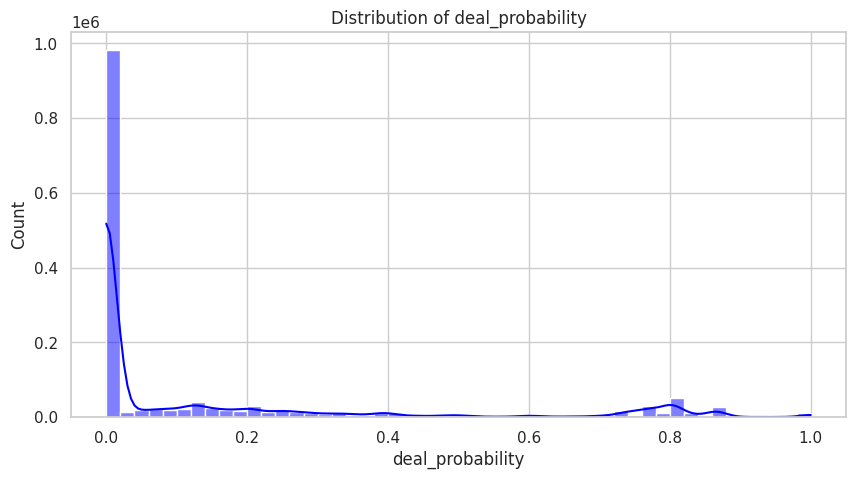

In [26]:
# Distribution of Target Variable – deal_probability

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(train['deal_probability'], bins=50, kde=True, color='blue')
plt.title('Distribution of deal_probability')
plt.xlabel('deal_probability')
plt.ylabel('Count')
plt.grid(True)
plt.show()


In [27]:
# Category Column Exploration

categorical_cols = ['region', 'city', 'parent_category_name', 'category_name', 'user_type']

for col in categorical_cols:
    print(f"\nValue counts for {col}:")
    print(train[col].value_counts().head())



Value counts for region:
region
Краснодарский край      141416
Свердловская область     94475
Ростовская область       89995
Татарстан                81284
Челябинская область      78339
Name: count, dtype: int64

Value counts for city:
city
Краснодар          63638
Екатеринбург       63602
Новосибирск        56929
Ростов-на-Дону     52323
Нижний Новгород    52010
Name: count, dtype: int64

Value counts for parent_category_name:
parent_category_name
Личные вещи            697623
Для дома и дачи        178823
Бытовая электроника    173008
Недвижимость           153190
Хобби и отдых           86011
Name: count, dtype: int64

Value counts for category_name:
category_name
Одежда, обувь, аксессуары     282753
Детская одежда и обувь        270359
Товары для детей и игрушки     99747
Квартиры                       83670
Телефоны                       65944
Name: count, dtype: int64

Value counts for user_type:
user_type
Private    1075706
Company     347249
Shop         80469
Name: count, dt

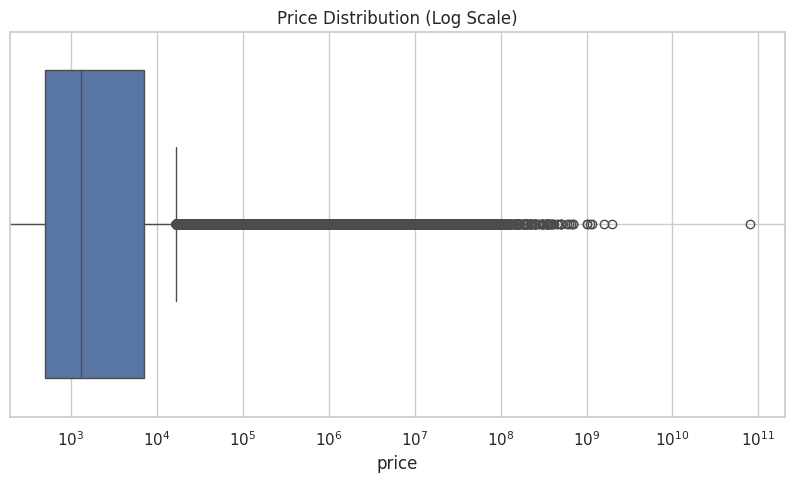

In [28]:
# Price Distribution (Log Scale)

plt.figure(figsize=(10, 5))
sns.boxplot(x=train['price'])
plt.xscale('log')  # Log scale for better visibility
plt.title('Price Distribution (Log Scale)')
plt.xlabel('price')
plt.grid(True)
plt.show()


### EDA Sumary

#### Target Value– deal_probability

- The value of 0.0 is quite dominant. This means most listings did not convert into sales.

- The distribution is skewed to the right, with most values clustered between 0.0 and 0.2.

- This indicates an unbalanced target variable → this should be taken into account during modeling (e.g., log-transformation is not required, but custom loss functions can be considered).

#### price Variable
- Extreme outliers are present (e.g., values above 10⁹).

- The log scale boxplot clearly demonstrates this.

- During data cleaning:

  - Extreme outliers should be eliminated (limits such as price > 10^6 can be tried).

  - Missing prices should be filled in or may not be included in the model.

→ param_2 ve param_3 is very incomplete; therefore, it is either filled in as "missing" instead of "NaN" or used optionally in the model.

### Feature Engineering

#### Planned Feature Engineering:

1. Price column cleanup (outliers and log transformation)
2. Filling in missing data
3. param_1, param_2, param_3 → fill in missing data as "missing"
4. Date attributes (activation_date) → day, month, weekend
5. Length-based attributes: title_len, desc_len, num_images
6. Digitizing categorical variables with Label Encoding
7. Columns such as user_type, region, parent_category_name, and category_name will be prepared for encoding

In [29]:
# Data Cleaning & Feature Engineering

from sklearn.preprocessing import LabelEncoder
import numpy as np

# Copy dataset
df = train.copy()

# Fill missing param values with 'missing'
for col in ['param_1', 'param_2', 'param_3']:
    df[col] = df[col].fillna('missing')

# Fill missing description with empty string
df['description'] = df['description'].fillna('')

# Fill missing price with 0 and clip extreme values
df['price'] = df['price'].fillna(0)
df['price'] = df['price'].clip(0, 1e6)  # Remove outliers
df['log_price'] = np.log1p(df['price'])  # Log transform

# Fill missing image columns
df['image'] = df['image'].fillna('no_image')
df['image_top_1'] = df['image_top_1'].fillna(-1).astype(int)

# Date features
df['activation_date'] = pd.to_datetime(df['activation_date'])
df['activation_weekday'] = df['activation_date'].dt.weekday
df['activation_week'] = df['activation_date'].dt.isocalendar().week
df['activation_day'] = df['activation_date'].dt.day
df['activation_month'] = df['activation_date'].dt.month

# Text length features
df['title_len'] = df['title'].apply(lambda x: len(str(x)))
df['description_len'] = df['description'].apply(lambda x: len(str(x).split()))

# Encode categorical variables (Label Encoding)
cat_cols = ['region', 'city', 'parent_category_name', 'category_name',
            'param_1', 'param_2', 'param_3', 'user_type']

le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le  # Save encoders for future use

# Final features for training
feature_cols = ['region', 'city', 'parent_category_name', 'category_name',
                'param_1', 'param_2', 'param_3', 'user_type',
                'log_price', 'item_seq_number', 'image_top_1',
                'activation_weekday', 'activation_week', 'activation_day', 'activation_month',
                'title_len', 'description_len']

X = df[feature_cols]
y = df['deal_probability']


In [30]:
print("X shape:", X.shape)
print("Target (y) preview:", y.head())


X shape: (1503424, 17)
Target (y) preview: 0    0.12789
1    0.00000
2    0.43177
3    0.80323
4    0.20797
Name: deal_probability, dtype: float64


In [33]:
# LightGBM Model Training

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

# Split the data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42)

# LightGBM datasets
train_set = lgb.Dataset(X_train, y_train)
val_set = lgb.Dataset(X_val, y_val)

# Model parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'verbose': -1,
    'random_state': 42
}

# Train the model with callbacks
model = lgb.train(
    params,
    train_set,
    valid_sets=[train_set, val_set],
    num_boost_round=1000,
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=100)
    ]
)

# Predictions and RMSE
y_pred = model.predict(X_val)

# Calculate RMSE manually
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print(f"\nValidation RMSE: {rmse:.5f}")


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.230327	valid_1's rmse: 0.230372
[200]	training's rmse: 0.228439	valid_1's rmse: 0.228827
[300]	training's rmse: 0.227216	valid_1's rmse: 0.228039
[400]	training's rmse: 0.226212	valid_1's rmse: 0.227469
[500]	training's rmse: 0.225402	valid_1's rmse: 0.227111
[600]	training's rmse: 0.224659	valid_1's rmse: 0.226828
[700]	training's rmse: 0.224026	valid_1's rmse: 0.226638
[800]	training's rmse: 0.223407	valid_1's rmse: 0.226472
[900]	training's rmse: 0.222833	valid_1's rmse: 0.226333
[1000]	training's rmse: 0.222296	valid_1's rmse: 0.226237
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.222296	valid_1's rmse: 0.226237

Validation RMSE: 0.22624


In [34]:
!pip install optuna -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 15.6 MB/s eta 0:00:00


In [37]:
# Optuna ile LightGBM Tuning

import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split once to speed up
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.1),
        'num_leaves': trial.suggest_int("num_leaves", 31, 256),
        'min_child_samples': trial.suggest_int("min_child_samples", 10, 100),
        'feature_fraction': trial.suggest_float("feature_fraction", 0.6, 1.0),
        'bagging_fraction': trial.suggest_float("bagging_fraction", 0.6, 1.0),
        'bagging_freq': trial.suggest_int("bagging_freq", 1, 10),
        'max_depth': trial.suggest_int("max_depth", 5, 20),
    }

    train_set = lgb.Dataset(X_train, y_train)
    val_set = lgb.Dataset(X_val, y_val)

    model = lgb.train(
        param,
        train_set,
        valid_sets=[val_set],
        num_boost_round=1000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=False),
            lgb.log_evaluation(period=0)
        ]
    )

    preds = model.predict(X_val)
    mse = mean_squared_error(y_val, preds)
    rmse = np.sqrt(mse)
    return rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

print("✅ Best parameters:", study.best_trial.params)
print("✅ Best RMSE:", study.best_value)


[I 2025-07-21 07:55:35,992] A new study created in memory with name: no-name-33225ee8-2133-486b-9c82-99af0ac1282c
[I 2025-07-21 07:56:36,317] Trial 0 finished with value: 0.2262966727411082 and parameters: {'learning_rate': 0.017017337474511503, 'num_leaves': 144, 'min_child_samples': 44, 'feature_fraction': 0.6312660883127228, 'bagging_fraction': 0.7128178591331684, 'bagging_freq': 10, 'max_depth': 15}. Best is trial 0 with value: 0.2262966727411082.
[I 2025-07-21 07:57:40,635] Trial 1 finished with value: 0.22529858566572908 and parameters: {'learning_rate': 0.08671680112150357, 'num_leaves': 190, 'min_child_samples': 39, 'feature_fraction': 0.9498427124233668, 'bagging_fraction': 0.9428528399477862, 'bagging_freq': 6, 'max_depth': 8}. Best is trial 1 with value: 0.22529858566572908.
[I 2025-07-21 07:58:31,619] Trial 2 finished with value: 0.22599161967160025 and parameters: {'learning_rate': 0.07168335184139563, 'num_leaves': 75, 'min_child_samples': 64, 'feature_fraction': 0.895082

✅ Best parameters: {'learning_rate': 0.04194451575633416, 'num_leaves': 235, 'min_child_samples': 53, 'feature_fraction': 0.7220911449895095, 'bagging_fraction': 0.9952911543686582, 'bagging_freq': 5, 'max_depth': 17}
✅ Best RMSE: 0.22498797236204066


In [39]:
# Final Model Training

best_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'random_state': 42,
    'learning_rate': 0.04194451575633416,
    'num_leaves': 235,
    'min_child_samples': 53,
    'feature_fraction': 0.7220911449895095,
    'bagging_fraction': 0.9952911543686582,
    'bagging_freq': 5,
    'max_depth': 17,
}

train_set = lgb.Dataset(X, y)

final_model = lgb.train(
    best_params,
    train_set,
    num_boost_round=1000,
    callbacks=[
        lgb.log_evaluation(period=100)
    ]
)



In [40]:
# Test Prediction & Submission

# Copy test dataframe
test_df = test.copy()

# Fill missing values
for col in ['param_1', 'param_2', 'param_3']:
    test_df[col] = test_df[col].fillna('missing')
test_df['description'] = test_df['description'].fillna('')
test_df['price'] = test_df['price'].fillna(0).clip(0, 1e6)
test_df['log_price'] = np.log1p(test_df['price'])
test_df['image'] = test_df['image'].fillna('no_image')
test_df['image_top_1'] = test_df['image_top_1'].fillna(-1).astype(int)
test_df['activation_date'] = pd.to_datetime(test_df['activation_date'])
test_df['activation_weekday'] = test_df['activation_date'].dt.weekday
test_df['activation_week'] = test_df['activation_date'].dt.isocalendar().week
test_df['activation_day'] = test_df['activation_date'].dt.day
test_df['activation_month'] = test_df['activation_date'].dt.month
test_df['title_len'] = test_df['title'].apply(lambda x: len(str(x)))
test_df['description_len'] = test_df['description'].apply(lambda x: len(str(x).split()))

# Label encoding (same as train)
for col in le_dict:
    test_df[col] = test_df[col].map(lambda s: s if s in le_dict[col].classes_ else 'missing')
    le_dict[col].classes_ = np.append(le_dict[col].classes_, 'missing')
    test_df[col] = le_dict[col].transform(test_df[col])

# Select features
X_test = test_df[feature_cols]

# Predict
test_preds = final_model.predict(X_test)
test_preds = np.clip(test_preds, 0, 1)  # Ensure range [0,1]

# Create submission
submission = pd.DataFrame({
    'item_id': test_df['item_id'],
    'deal_probability': test_preds
})

submission.to_csv('submission.csv', index=False)
print("✅ submission.csv saved successfully.")


✅ submission.csv saved successfully.


In [41]:
# Save model to file

final_model.save_model('final_lgbm_model.txt')
print("✅ Model saved as final_lgbm_model.txt")


✅ Model saved as final_lgbm_model.txt


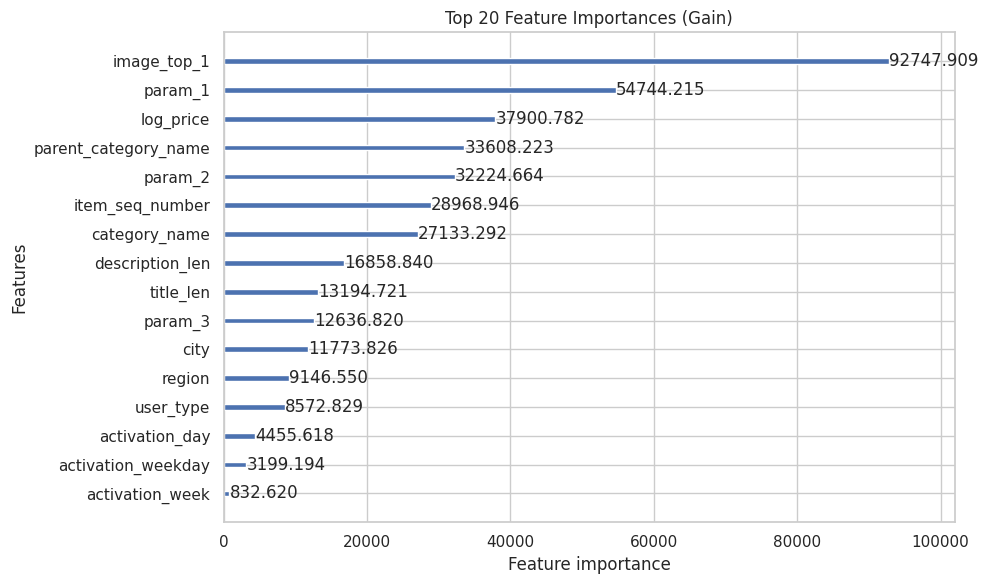

In [42]:
# Feature Importance Visualization

import matplotlib.pyplot as plt

# Plot top 20 most important features
lgb.plot_importance(final_model, max_num_features=20, importance_type='gain', figsize=(10, 6))
plt.title("Top 20 Feature Importances (Gain)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [43]:
# Text-Based Prediction with TF-IDF + Ridge Regression

from sklearn.linear_model import Ridge
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import scipy.sparse as sp
import numpy as np


In [45]:
# Merge texts

train['text'] = train['title'].fillna('') + ' ' + train['description'].fillna('')
test['text'] = test['title'].fillna('') + ' ' + test['description'].fillna('')

# TF-IDF features (title + description)
tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2),
    stop_words=None
)

X_text = tfidf.fit_transform(train['text'])
X_test_text = tfidf.transform(test['text'])

y_text = train['deal_probability']


In [46]:
# Evaluation with # Split for validation
X_train_text, X_val_text, y_train_text, y_val_text = train_test_split(
    X_text, y_text, test_size=0.2, random_state=42)

# Ridge model
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train_text, y_train_text)

# Predict & Evaluate
val_preds = ridge.predict(X_val_text)
rmse_ridge = np.sqrt(mean_squared_error(y_val_text, val_preds))
print(f"✅ Ridge Validation RMSE: {rmse_ridge:.5f}")


✅ Ridge Validation RMSE: 0.23256


In [47]:
# Test predict

ridge_preds_test = ridge.predict(X_test_text)
ridge_preds_test = np.clip(ridge_preds_test, 0, 1)  # Bound between 0 and 1


In [48]:
# Ensemble (LightGBM + Ridge) Prediction Submission

# Ensemble predictions: weighted average
final_preds = 0.6 * test_preds + 0.4 * ridge_preds_test
final_preds = np.clip(final_preds, 0, 1)  # Make sure predictions are in [0, 1]

# Create submission file
submission_ensemble = pd.DataFrame({
    'item_id': test['item_id'],
    'deal_probability': final_preds
})

submission_ensemble.to_csv('submission_ensemble.csv', index=False)
print("✅ Ensemble submission.csv saved as submission_ensemble.csv")


✅ Ensemble submission.csv saved as submission_ensemble.csv


In [49]:
import joblib

# Save Ridge model

joblib.dump(ridge, 'ridge_model.pkl')
print("✅ Ridge model saved as ridge_model.pkl")


✅ Ridge model saved as ridge_model.pkl


In [50]:
# Save the trained vectorizer used in Ridge model

joblib.dump(tfidf, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']